# MCU Model Performance Analysis

This notebook visualizes the performance of deployed LIF models on MCU, showing the relationship between maximum inference frequency and angular error.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the data
data = {
    'Model': [
        'baseline', 'layers', 'channels', 'channels', 'channels', 'input resolution', 'input resolution', 'input resolution',
    ],
    'Specs': [
        '32ch., 256x256, 8l., rec.', '6 layers', '16ch.', '8ch.', '4ch.', '128x128', '64x64', '32x32',
    ],
    'N. Operations [M ops.]': [7380, 4951, 1878, 486, 129, 1845, 461, 115],
    'AEE [pixels]': [2.7, 2.9, 2.9, 3.2, 3.4, 2.76, 2.9, 2.93],
    'AAE [degrees]': [24, 29, 30, 42, 60, 44, 62, 73],
    'Static Memory Allocation [MB]': [76, 59, 38, 19, 10, 19, 5, 1]
}

df = pd.DataFrame(data)
print("Data loaded successfully:")
print(df)

Data loaded successfully:
              Model                      Specs  N. Operations [M ops.]  \
0          baseline  32ch., 256x256, 8l., rec.                    7380   
1            layers                   6 layers                    4951   
2          channels                      16ch.                    1878   
3          channels                       8ch.                     486   
4          channels                       4ch.                     129   
5  input resolution                    128x128                    1845   
6  input resolution                      64x64                     461   
7  input resolution                      32x32                     115   

   AEE [pixels]  AAE [degrees]  Static Memory Allocation [MB]  
0          2.70             24                             76  
1          2.90             29                             59  
2          2.90             30                             38  
3          3.20             42                     

In [2]:
FULL_DATASET = {
    'Model': [
        '8L 256x256 32CH', '8L 256x256 16CH', '8L 256x256 8CH', '8L 256x256 4CH', '8L 128x128 32CH', '8L 128x128 16CH', '8L 128x128 8CH', '8L 128x128 4CH',
        '8L 64x64 32CH', '8L 64x64 16CH', '8L 64x64 8CH', '8L 64x64 4CH', '8L 32x32 32CH', '8L 32x32 16CH', '8L 32x32 8CH', '8L 32x32 4CH',
        '6L 256x256 32CH', '6L 256x256 16CH', '6L 256x256 8CH', '6L 256x256 4CH', '6L 128x128 32CH', '6L 128x128 16CH', '6L 128x128 8CH', '6L 128x128 4CH',
        '6L 64x64 32CH', '6L 64x64 16CH', '6L 64x64 8CH', '6L 64x64 4CH', '6L 32x32 32CH', '6L 32x32 16CH', '6L 32x32 8CH', '6L 32x32 4CH'
    ],
    'N. Operations [M ops.]': [7380, 1878, 486, 129, 1845, 469, 121, 32, 461, 117, 30, 8, 115, 29, 7, 2,
                               4951, 1267, 332, 90, 1237, 316, 83, 22, 309, 79, 20, 5, 77, 19, 5, 1],
    'Max Frequency [Hz] at 360 MHz': [None, None, None, None, None, None, 1.6, 0.9, 0.5, 1.6, 7.3, 9.4, 2.3, 12.6, 42.4, 68.2,
                                       None, None, None, 0.3, None, 0.4, 2.1, 1.2, 0.7, 2.3, 9.8, 13.5, 3.3, 18.5, 60.4, 95.1],
    'Runtime [M cycles]': [None, None, None, None, None, None, 223, 410, 706, 224, 49, 38, 155, 28, 8, 5,
                           None, None, None, 1313, None, 869, 170, 296, 490, 159, 36, 26, 107, 19, 5, 3],
    'AEE [pixels]': [2.7, 2.91, 3.21, 3.44, 2.44, 2.74, 3, 3.12, 2.68, 2.97, 3.03, 3.15, 2.79, 3.04, 3.06, 3.16,
                     2.86, 2.84, 3.37, 3.72, 2.8, 2.59, 3.04, 3.3, 3.12, 2.85, 3.07, 3.23, 3.25, 3.01, 3.05, 3.22],
    'AAE [degrees]': [24, 30, 42, 60, 30, 39, 57, 65, 49, 57, 70, 78, 65, 71, 81, 89,
                      29, 28, 54, 76, 41, 33, 62, 78, 63, 51, 76, 84, 79, 69, 83, 89],
    'Static Memory Allocation [MB]': [76.8, 38.8, 19.9, 10.5, 19.4, 9.8, 5, 2.6, 5, 2.5, 1.3, 0.7, 1.4, 0.7, 0.3, 0.2,
                                      59.9, 30.4, 15.7, 8.4, 15.1, 7.6, 3.9, 2.1, 3.9, 1.9, 1, 0.5, 1.1, 0.5, 0.2, 0.1]
}

df_full = pd.DataFrame(FULL_DATASET)
print("Data loaded successfully:")
print(df_full)

Data loaded successfully:
              Model  N. Operations [M ops.]  Max Frequency [Hz] at 360 MHz  \
0   8L 256x256 32CH                    7380                            NaN   
1   8L 256x256 16CH                    1878                            NaN   
2    8L 256x256 8CH                     486                            NaN   
3    8L 256x256 4CH                     129                            NaN   
4   8L 128x128 32CH                    1845                            NaN   
5   8L 128x128 16CH                     469                            NaN   
6    8L 128x128 8CH                     121                            1.6   
7    8L 128x128 4CH                      32                            0.9   
8     8L 64x64 32CH                     461                            0.5   
9     8L 64x64 16CH                     117                            1.6   
10     8L 64x64 8CH                      30                            7.3   
11     8L 64x64 4CH                   

/tmp/ipykernel_5352/853649400.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 8000)


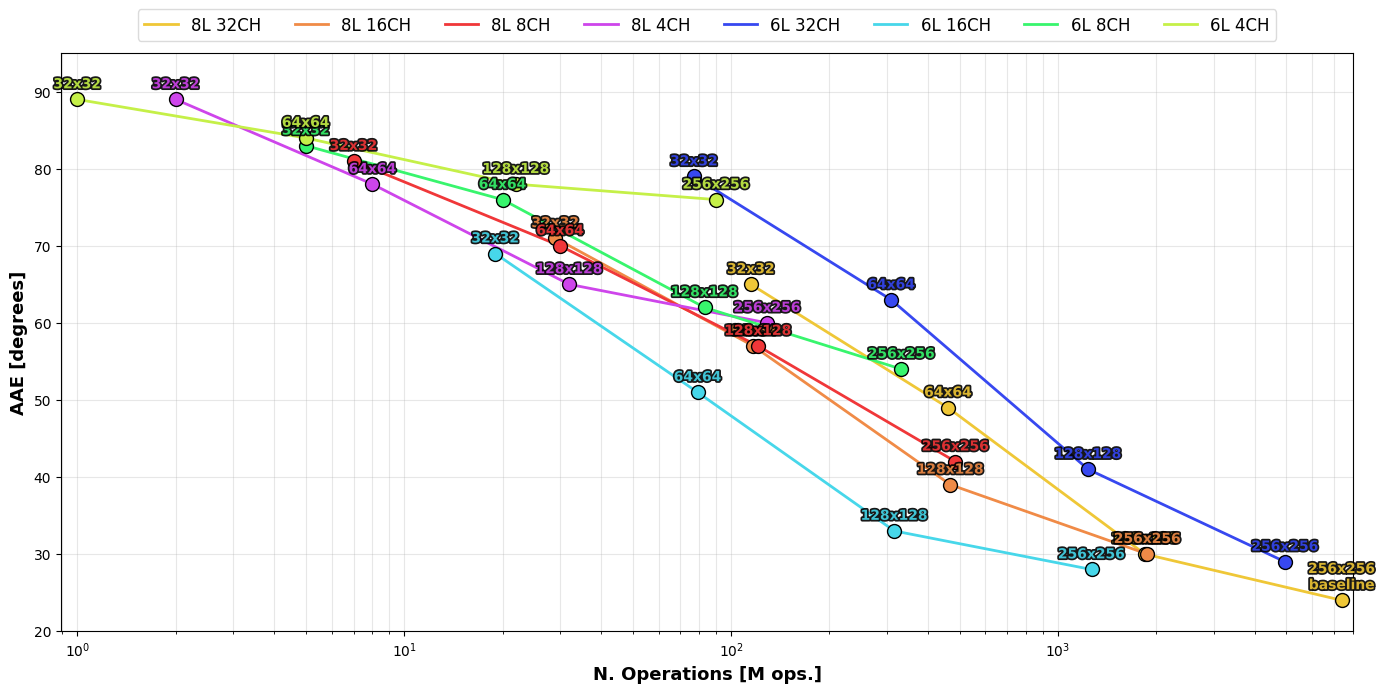

Total groups with data: 8
8L 32CH: 4 points
8L 16CH: 4 points
8L 8CH: 4 points
8L 4CH: 4 points
6L 32CH: 4 points
6L 16CH: 4 points
6L 8CH: 4 points
6L 4CH: 4 points


In [13]:
# CURVES BASED ON SPECIFIC MODELS BASED ON INPUT RESOLUTION (ANGULAR ERROR):
# 8 curves: FN/FNs with each channel count (32ch, 16ch, 8ch, 4ch) across all resolutions

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, channel, and resolution information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]

# Create labels showing only resolution (what varies along each curve)
df_filtered['Label'] = df_filtered['Resolution']

# Group by layer type and channel count
layer_channel_groups = {}
for layer_type in ['8L', '6L']:
    for ch in [32, 16, 8, 4]:
        key = f'{layer_type} {ch}CH'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Channels'] == ch)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_channel_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AAE [degrees]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 8000)
ax1.set_ylim(20, 95)
ax1.grid(True, alpha=0.3, which='both')

""" # Second y axis for memory
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=13, fontweight='bold', labelpad=5)
ax2.set_ylim(0, max(df_filtered['Static Memory Allocation [MB]']) * 1.1) """

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 32CH': '#EFC737',    
    '8L 16CH': '#F08B47',   
    '8L 8CH': '#F03739',     
    '8L 4CH': '#CE45EB',     
    '6L 32CH': '#3748F0',   
    '6L 16CH': '#47D7EA',   
    '6L 8CH': '#38F56D',    
    '6L 4CH': '#C5F048'     
}

# Plot memory bars for each group
bar_width_factor = 0.10
offset_start = 0.85
offset_step = 0.04
offset_factors = {key: offset_start + i * offset_step for i, key in enumerate(layer_channel_groups.keys())}

""" for group_name, df_group in layer_channel_groups.items():
    for idx, row in df_group.iterrows():
        bar_width = row['N. Operations [M ops.]'] * bar_width_factor
        ax2.bar(row['N. Operations [M ops.]'], 
               row['Static Memory Allocation [MB]'],
               width=bar_width, color=colors[group_name], alpha=0.2, align='center', 
               zorder=5, edgecolor='black', linewidth=1.0) """

# Plot curves for each group
for group_name, df_group in layer_channel_groups.items():
    # Sort by runtime
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Plot line
    ax1.plot(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AAE [degrees]'], 
            linestyle='-', color=colors[group_name], linewidth=2, label=group_name, zorder=2)
    
    # Plot scatter points
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AAE [degrees]'], 
               color=colors[group_name], s=100, edgecolor='black', zorder=3)
    
    # Add labels for each point (showing only resolution)
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 32CH' and row['Label'] == '256x256':
            label_text = f"\nbaseline"
        else:
            label_text = f""
        ax1.annotate(f"{row['Label']}{label_text}", 
                    (row['N. Operations [M ops.]'], row['AAE [degrees]']), 
                    textcoords="offset points", xytext=(0, 8), ha='center', 
                    fontsize=10, color=colors[group_name], fontweight='bold', alpha=0.9, zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])

legend = ax1.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.09), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_channel_groups)}")
for group_name, df_group in layer_channel_groups.items():
    print(f"{group_name}: {len(df_group)} points")

/tmp/ipykernel_5352/433937554.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 10000)


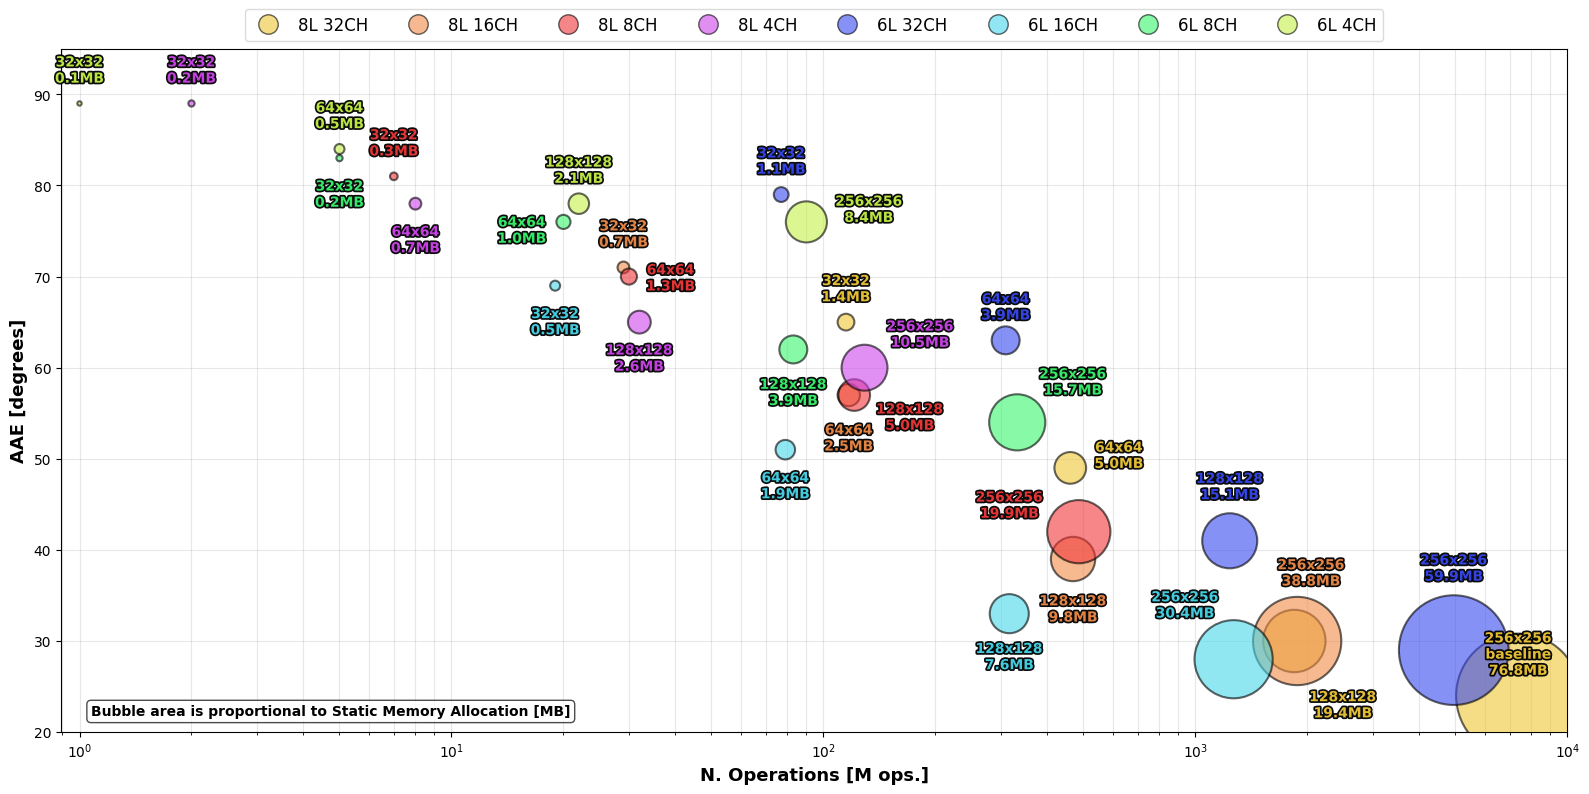

Total groups with data: 8
8L 32CH: 4 points
8L 16CH: 4 points
8L 8CH: 4 points
8L 4CH: 4 points
6L 32CH: 4 points
6L 16CH: 4 points
6L 8CH: 4 points
6L 4CH: 4 points

Memory allocation range: 0.10 - 76.80 MB
Bubble area range: 10 - 8000 points²


In [56]:
# BUBBLE PLOT

# CURVES BASED ON SPECIFIC MODELS BASED ON INPUT RESOLUTION (ANGULAR ERROR):
# 8 curves: FN/FNs with each channel count (32ch, 16ch, 8ch, 4ch) across all resolutions

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
import numpy as np

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, channel, and resolution information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]

# Create labels showing only resolution (what varies along each curve)
df_filtered['Label'] = df_filtered['Resolution']

# Group by layer type and channel count
layer_channel_groups = {}
for layer_type in ['8L', '6L']:
    for ch in [32, 16, 8, 4]:
        key = f'{layer_type} {ch}CH'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Channels'] == ch)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_channel_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AAE [degrees]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 10000)
ax1.set_ylim(20, 95)
ax1.grid(True, alpha=0.3, which='both')

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 32CH': '#EFC737',    
    '8L 16CH': '#F08B47',   
    '8L 8CH': '#F03739',     
    '8L 4CH': '#CE45EB',     
    '6L 32CH': '#3748F0',   
    '6L 16CH': '#47D7EA',   
    '6L 8CH': '#38F56D',    
    '6L 4CH': '#C5F048'     
}

# Calculate bubble sizes based on memory allocation
# Linear scaling: area proportional to memory value
min_mem = df_filtered['Static Memory Allocation [MB]'].min()
max_mem = df_filtered['Static Memory Allocation [MB]'].max()
min_size = 10   # area for smallest bubble
max_size = 8000  # area for largest bubble

def scale_bubble_size(memory_value):
    # Linear scaling for area
    return min_size + (memory_value - min_mem) / (max_mem - min_mem) * (max_size - min_size)

# Manual label offset dictionary
# Key: (group_name, resolution), Value: (x_offset, y_offset)
label_offsets = {
    # Example: ('8L 32CH', '346x260'): (0, 25),
    # Fill in with your preferred offsets for each label
    # ('group_name', 'resolution'): (x_offset, y_offset)
    ('6L 8CH', '32x32'): (0, -35),
    ('8L 4CH', '64x64'): (0, -35),
    ('6L 16CH', '32x32'): (0, -35),
    ('8L 4CH', '128x128'): (0, -35),
    ('6L 16CH', '64x64'): (0, -35),
    ('8L 16CH', '64x64'): (0, -40),
    ('6L 16CH', '128x128'): (0, -40),
    ('6L 8CH', '64x64'): (-30, -15),
    ('8L 8CH', '64x64'): (30, -10),
    ('6L 8CH', '128x128'): (0, -40),
    ('6L 4CH', '256x256'): (45, 0),
    ('8L 4CH', '256x256'): (40, 15),
    ('8L 8CH', '128x128'): (40, -25),
    ('6L 8CH', '256x256'): (40, 20),
    ('8L 32CH', '64x64'): (35, 0),
    ('8L 16CH', '128x128'): (0, -45),
    ('8L 8CH', '256x256'): (-50, 10),
    ('6L 32CH', '128x128'): (0, 30),
    ('6L 32CH', '256x256'): (0, 50),
    ('6L 16CH', '256x256'): (-35, 30),
    ('8L 16CH', '256x256'): (10, 40),
    ('8L 32CH', '128x128'): (35, -55),

}
def get_label_offset(group_name, resolution):
    return label_offsets.get((group_name, resolution), (0, 15))  # Default offset if not specified

# Plot bubble scatter for each group
legend_handles = []
for group_name, df_group in layer_channel_groups.items():
    # Sort by operations for consistent plotting
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Calculate bubble sizes for this group
    bubble_sizes = [scale_bubble_size(mem) for mem in df_group_sorted['Static Memory Allocation [MB]']]
    
    """ # Plot thin line connecting bubbles
    ax1.plot(df_group_sorted['N. Operations [M ops.]'],
             df_group_sorted['AAE [degrees]'],
             color=colors[group_name],
             linewidth=1.2,
             alpha=0.5,
             zorder=2) """
    
    # Plot scatter points with sizes based on memory allocation
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], 
               df_group_sorted['AAE [degrees]'], 
               s=bubble_sizes,
               color=colors[group_name], 
               alpha=0.6,
               edgecolor='black',
               linewidth=1.5,
               label=group_name, 
               zorder=3)
    
    # Add labels for each point showing both resolution and memory
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 32CH' and row['Label'] == '256x256':
            label_text = f"{row['Label']}\nbaseline\n{row['Static Memory Allocation [MB]']:.1f}MB"
        else:
            label_text = f"{row['Label']}\n{row['Static Memory Allocation [MB]']:.1f}MB"
        offset_x, offset_y = get_label_offset(group_name, row['Label'])
        ax1.annotate(label_text, 
                    (row['N. Operations [M ops.]'], row['AAE [degrees]']), 
                    textcoords="offset points", 
                    xytext=(offset_x, offset_y), 
                    ha='center', 
                    fontsize=10, 
                    color=colors[group_name], 
                    fontweight='bold', 
                    alpha=0.95, 
                    zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])
    # Create legend handle with fixed size
    legend_handles.append(
        mlines.Line2D([], [], color=colors[group_name], marker='o', linestyle='None', markersize=14, label=group_name, markeredgecolor='black', alpha=0.6)
    )

legend = ax1.legend(handles=legend_handles, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

# Add a note about bubble size meaning
ax1.text(0.02, 0.02, 'Bubble area is proportional to Static Memory Allocation [MB]', 
        transform=ax1.transAxes, fontsize=10, fontweight='bold',
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_channel_groups)}")
for group_name, df_group in layer_channel_groups.items():
    print(f"{group_name}: {len(df_group)} points")
print(f"\nMemory allocation range: {min_mem:.2f} - {max_mem:.2f} MB")
print(f"Bubble area range: {scale_bubble_size(min_mem):.0f} - {scale_bubble_size(max_mem):.0f} points²")


/tmp/ipykernel_5352/3733031979.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 8000)


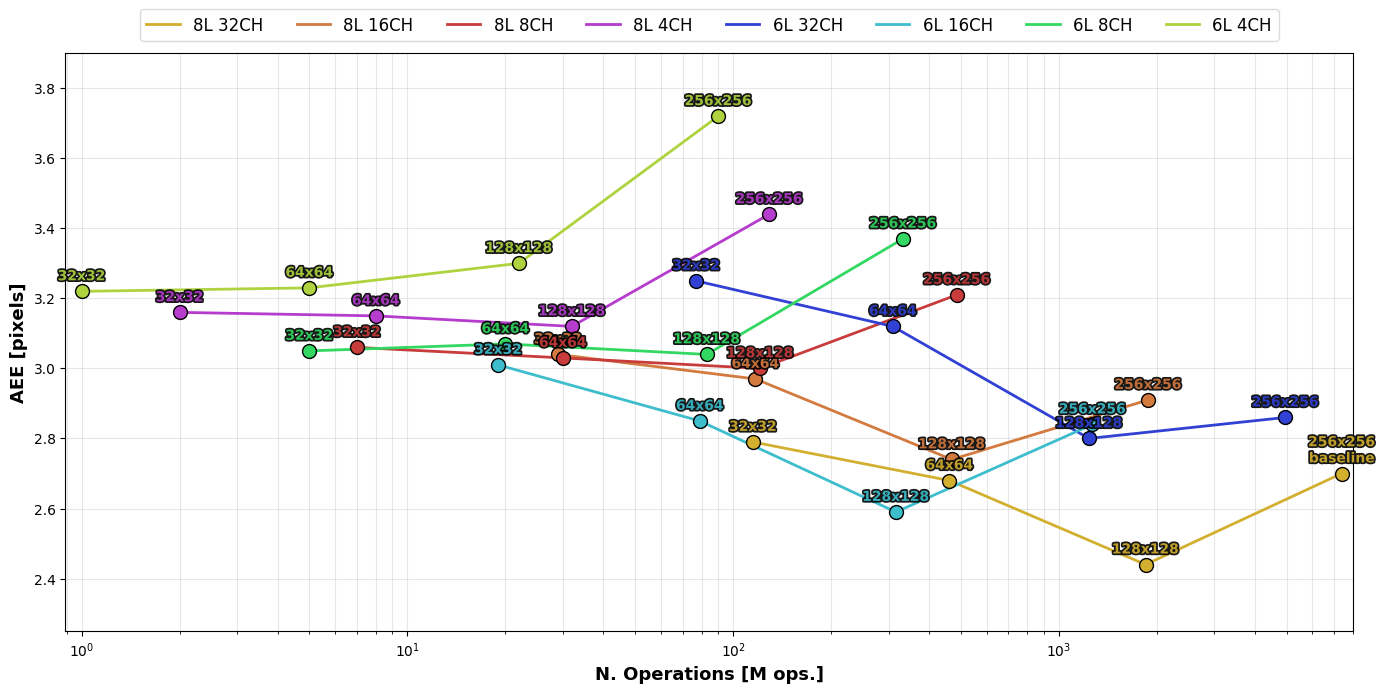

Total groups with data: 8
8L 32CH: 4 points
8L 16CH: 4 points
8L 8CH: 4 points
8L 4CH: 4 points
6L 32CH: 4 points
6L 16CH: 4 points
6L 8CH: 4 points
6L 4CH: 4 points


In [65]:
# CURVES BASED ON SPECIFIC MODELS BASED ON INPUT RESOLUTION (MODULUS ERROR):
# 8 curves: FN/FNs with each channel count (32ch, 16ch, 8ch, 4ch) across all resolutions

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, channel, and resolution information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]

# Create labels showing only resolution (what varies along each curve)
df_filtered['Label'] = df_filtered['Resolution']

# Group by layer type and channel count
layer_channel_groups = {}
for layer_type in ['8L', '6L']:
    for ch in [32, 16, 8, 4]:
        key = f'{layer_type} {ch}CH'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Channels'] == ch)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_channel_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AEE [pixels]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 8000)
ax1.set_ylim(2.25, 3.9)
ax1.grid(True, alpha=0.3, which='both')

""" # Second y axis for memory
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=13, fontweight='bold', labelpad=5)
ax2.set_ylim(0, max(df_filtered['Static Memory Allocation [MB]']) * 1.1) """

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 32CH': '#D3AF30',    
    '8L 16CH': '#D37A3F',   
    '8L 8CH': '#C83C3C',     
    '8L 4CH': '#B53CCD',     
    '6L 32CH': '#3041D3',   
    '6L 16CH': '#3EBDCD',   
    '6L 8CH': '#32D861',    
    '6L 4CH': '#AED33F'     
}

# Plot memory bars for each group
bar_width_factor = 0.10
offset_start = 0.85
offset_step = 0.04
offset_factors = {key: offset_start + i * offset_step for i, key in enumerate(layer_channel_groups.keys())}

""" for group_name, df_group in layer_channel_groups.items():
    for idx, row in df_group.iterrows():
        bar_width = row['N. Operations [M ops.]'] * bar_width_factor
        ax2.bar(row['N. Operations [M ops.]'], 
               row['Static Memory Allocation [MB]'],
               width=bar_width, color=colors[group_name], alpha=0.2, align='center', 
               zorder=5, edgecolor='black', linewidth=1.0) """

# Plot curves for each group
for group_name, df_group in layer_channel_groups.items():
    # Sort by runtime
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Plot line
    ax1.plot(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AEE [pixels]'], 
            linestyle='-', color=colors[group_name], linewidth=2, label=group_name, zorder=2)
    
    # Plot scatter points
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AEE [pixels]'], 
               color=colors[group_name], s=100, edgecolor='black', zorder=3)
    
    # Add labels for each point (showing only resolution)
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 32CH' and row['Label'] == '256x256':
            label_text = f"\nbaseline"
        else:
            label_text = f""
        ax1.annotate(f"{row['Label']}{label_text}",  
                    (row['N. Operations [M ops.]'], row['AEE [pixels]']), 
                    textcoords="offset points", xytext=(0, 8), ha='center', 
                    fontsize=10, color=colors[group_name], fontweight='bold', alpha=0.9, zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])

legend = ax1.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.09), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_channel_groups)}")
for group_name, df_group in layer_channel_groups.items():
    print(f"{group_name}: {len(df_group)} points")

/tmp/ipykernel_5352/725202652.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 10000)


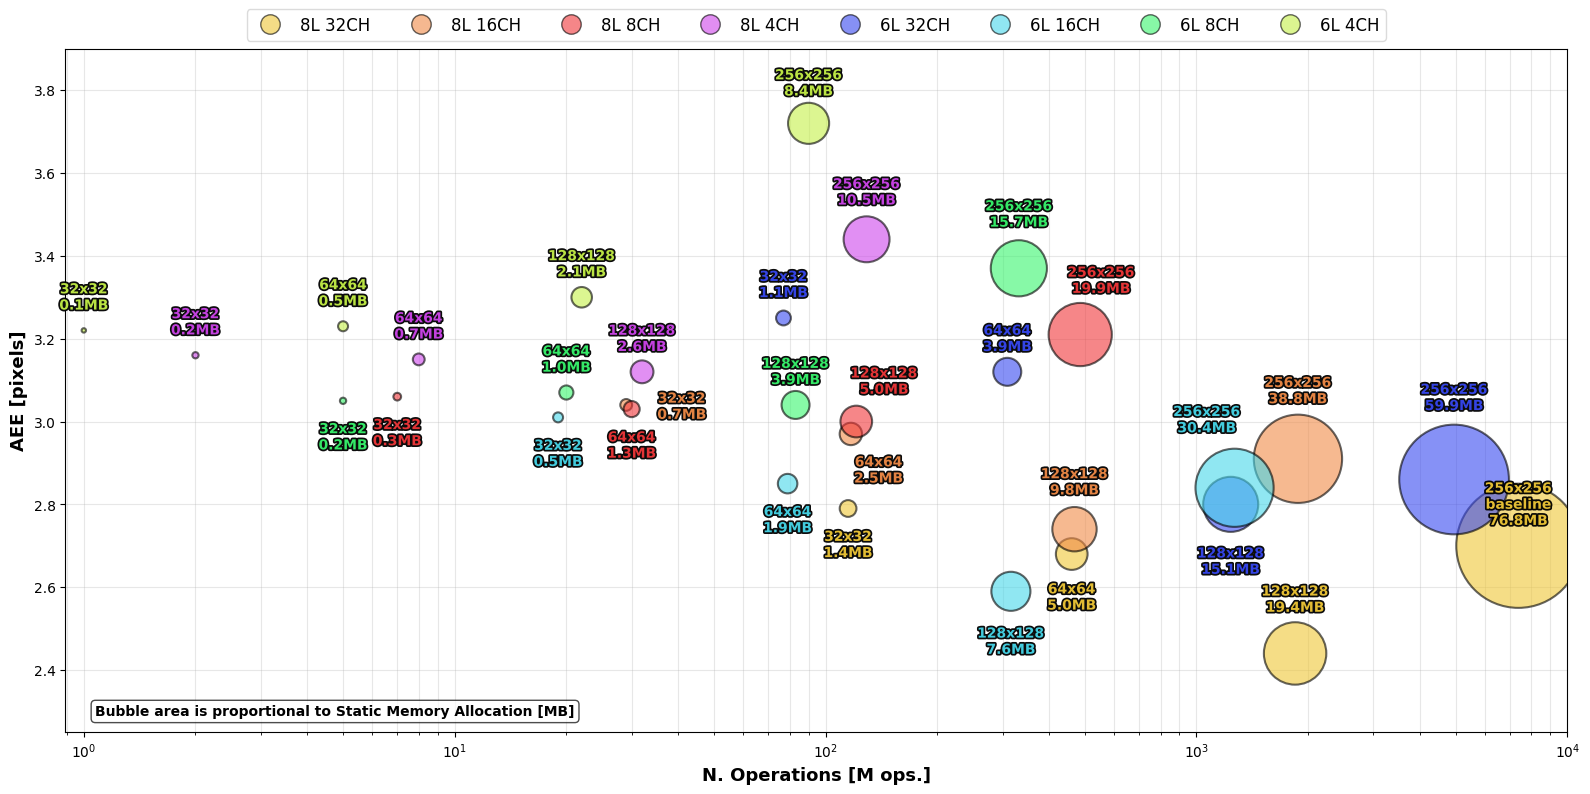

Total groups with data: 8
8L 32CH: 4 points
8L 16CH: 4 points
8L 8CH: 4 points
8L 4CH: 4 points
6L 32CH: 4 points
6L 16CH: 4 points
6L 8CH: 4 points
6L 4CH: 4 points

Memory allocation range: 0.10 - 76.80 MB
Bubble area range: 10 - 8000 points²


In [157]:
# BUBBLE PLOT

# CURVES BASED ON SPECIFIC MODELS BASED ON INPUT RESOLUTION (ENDPOINT ERROR):
# 8 curves: FN/FNs with each channel count (32ch, 16ch, 8ch, 4ch) across all resolutions

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
import numpy as np

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, channel, and resolution information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]

# Create labels showing only resolution (what varies along each curve)
df_filtered['Label'] = df_filtered['Resolution']

# Group by layer type and channel count
layer_channel_groups = {}
for layer_type in ['8L', '6L']:
    for ch in [32, 16, 8, 4]:
        key = f'{layer_type} {ch}CH'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Channels'] == ch)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_channel_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AEE [pixels]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 10000)
ax1.set_ylim(2.25, 3.9)
ax1.grid(True, alpha=0.3, which='both')

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 32CH': '#EFC737',    
    '8L 16CH': '#F08B47',   
    '8L 8CH': '#F03739',     
    '8L 4CH': '#CE45EB',     
    '6L 32CH': '#3748F0',   
    '6L 16CH': '#47D7EA',   
    '6L 8CH': '#38F56D',    
    '6L 4CH': '#C5F048'     
}

# Calculate bubble sizes based on memory allocation
# Linear scaling: area proportional to memory value
min_mem = df_filtered['Static Memory Allocation [MB]'].min()
max_mem = df_filtered['Static Memory Allocation [MB]'].max()
min_size = 10   # area for smallest bubble
max_size = 8000  # area for largest bubble

def scale_bubble_size(memory_value):
    # Linear scaling for area
    return min_size + (memory_value - min_mem) / (max_mem - min_mem) * (max_size - min_size)

# Manual label offset dictionary
# Key: (group_name, resolution), Value: (x_offset, y_offset)
label_offsets = {
    # Example: ('8L 32CH', '346x260'): (0, 25),
    # Fill in with your preferred offsets for each label
    # ('group_name', 'resolution'): (x_offset, y_offset)
    ('6L 8CH', '32x32'): (0, -35),
    ('8L 8CH', '32x32'): (0, -35),
    ('6L 16CH', '32x32'): (0, -35),
    ('8L 8CH', '64x64'): (0, -35),
    ('6L 16CH', '64x64'): (0, -35),
    ('8L 32CH', '32x32'): (0, -35),
    ('8L 16CH', '32x32'): (40, -10),
    ('8L 16CH', '64x64'): (20, -35),
    ('6L 4CH', '256x256'): (0, 20),
    ('8L 4CH', '256x256'): (0, 25),
    ('8L 8CH', '128x128'): (20, 20),
    ('6L 16CH', '128x128'): (0, -45),
    ('8L 32CH', '64x64'): (0, -40),
    ('8L 16CH', '128x128'): (0, 25),
    ('6L 8CH', '256x256'): (0, 30),
    ('8L 8CH', '256x256'): (15, 30),
    ('6L 32CH', '128x128'): (0, -50),
    ('8L 16CH', '256x256'): (0, 40),
    ('6L 32CH', '256x256'): (0, 50),
    ('6L 16CH', '256x256'): (-20, 40),
    ('8L 32CH', '128x128'): (0, 30),
}
def get_label_offset(group_name, resolution):
    return label_offsets.get((group_name, resolution), (0, 15))  # Default offset if not specified

# Plot bubble scatter for each group
legend_handles = []
for group_name, df_group in layer_channel_groups.items():
    # Sort by operations for consistent plotting
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Calculate bubble sizes for this group
    bubble_sizes = [scale_bubble_size(mem) for mem in df_group_sorted['Static Memory Allocation [MB]']]
    
    """ # Plot thin line connecting bubbles
    ax1.plot(df_group_sorted['N. Operations [M ops.]'],
             df_group_sorted['AEE [pixels]'],
             color=colors[group_name],
             linewidth=1.2,
             alpha=0.5,
             zorder=2) """
    
    # Plot scatter points with sizes based on memory allocation
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], 
               df_group_sorted['AEE [pixels]'], 
               s=bubble_sizes,
               color=colors[group_name], 
               alpha=0.6,
               edgecolor='black',
               linewidth=1.5,
               label=group_name, 
               zorder=3)
    
    # Add labels for each point showing both resolution and memory
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 32CH' and row['Label'] == '256x256':
            label_text = f"{row['Label']}\nbaseline\n{row['Static Memory Allocation [MB]']:.1f}MB"
        else:
            label_text = f"{row['Label']}\n{row['Static Memory Allocation [MB]']:.1f}MB"
        offset_x, offset_y = get_label_offset(group_name, row['Label'])
        ax1.annotate(label_text, 
                    (row['N. Operations [M ops.]'], row['AEE [pixels]']), 
                    textcoords="offset points", 
                    xytext=(offset_x, offset_y), 
                    ha='center', 
                    fontsize=10, 
                    color=colors[group_name], 
                    fontweight='bold', 
                    alpha=0.95, 
                    zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])
    # Create legend handle with fixed size
    legend_handles.append(
        mlines.Line2D([], [], color=colors[group_name], marker='o', linestyle='None', markersize=14, label=group_name, markeredgecolor='black', alpha=0.6)
    )

legend = ax1.legend(handles=legend_handles, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

# Add a note about bubble size meaning
ax1.text(0.02, 0.02, 'Bubble area is proportional to Static Memory Allocation [MB]', 
        transform=ax1.transAxes, fontsize=10, fontweight='bold',
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_channel_groups)}")
for group_name, df_group in layer_channel_groups.items():
    print(f"{group_name}: {len(df_group)} points")
print(f"\nMemory allocation range: {min_mem:.2f} - {max_mem:.2f} MB")
print(f"Bubble area range: {scale_bubble_size(min_mem):.0f} - {scale_bubble_size(max_mem):.0f} points²")

/tmp/ipykernel_5352/1077193615.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 8000)


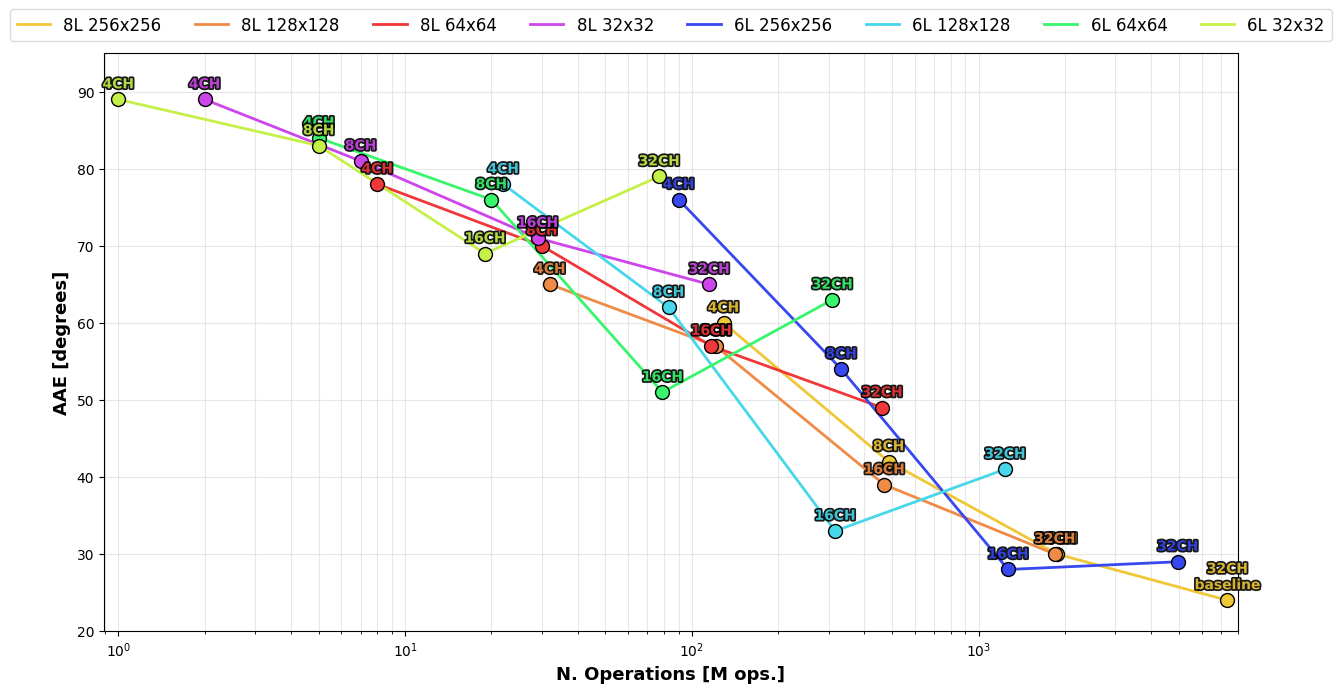

Total groups with data: 8
8L 256x256: 4 points
8L 128x128: 4 points
8L 64x64: 4 points
8L 32x32: 4 points
6L 256x256: 4 points
6L 128x128: 4 points
6L 64x64: 4 points
6L 32x32: 4 points


In [102]:
# CURVES BASED ON SPECIFIC MODELS BASED ON HIDDEN CHANNELS (ANGULAR ERROR):
# 8 curves: FN/FNs with each resolution (256x256, 128x128, 64x64, 32x32) across all channels

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, resolution, and channel information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)

# Create labels showing only channels (what varies along each curve)
df_filtered['Label'] = df_filtered['Channels'].astype(str) + 'CH'

# Group by layer type and resolution
layer_resolution_groups = {}
for layer_type in ['8L', '6L']:
    for res in ['256x256', '128x128', '64x64', '32x32']:
        key = f'{layer_type} {res}'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Resolution'] == res)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_resolution_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AAE [degrees]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 8000)
ax1.set_ylim(20, 95)
ax1.grid(True, alpha=0.3, which='both')

""" # Second y axis for memory
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=13, fontweight='bold', labelpad=5)
ax2.set_ylim(0, max(df_filtered['Static Memory Allocation [MB]']) * 1.1) """

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 256x256': '#EFC737',    
    '8L 128x128': '#F08B47',   
    '8L 64x64': '#F03739',     
    '8L 32x32': '#CE45EB',     
    '6L 256x256': '#3748F0',   
    '6L 128x128': '#47D7EA',   
    '6L 64x64': '#38F56D',    
    '6L 32x32': '#C5F048'
}

# Plot memory bars for each group
bar_width_factor = 0.10
offset_start = 0.85
offset_step = 0.04
offset_factors = {key: offset_start + i * offset_step for i, key in enumerate(layer_resolution_groups.keys())}

""" for group_name, df_group in layer_resolution_groups.items():
    for idx, row in df_group.iterrows():
        bar_width = row['N. Operations [M ops.]'] * bar_width_factor
        ax2.bar(row['N. Operations [M ops.]'], 
               row['Static Memory Allocation [MB]'],
               width=bar_width, color=colors[group_name], alpha=0.2, align='center', 
               zorder=5, edgecolor='black', linewidth=1.0) """

# Plot curves for each group
for group_name, df_group in layer_resolution_groups.items():
    # Sort by runtime
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Plot line
    ax1.plot(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AAE [degrees]'], 
            linestyle='-', color=colors[group_name], linewidth=2, label=group_name, zorder=2)
    
    # Plot scatter points
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AAE [degrees]'], 
               color=colors[group_name], s=100, edgecolor='black', zorder=3)
    
    # Add labels for each point (showing only channel count)
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 256x256' and row['Label'] == '32CH':
            label_text = f"\nbaseline"
        else:
            label_text = f""
        ax1.annotate(f"{row['Label']}{label_text}", 
                    (row['N. Operations [M ops.]'], row['AAE [degrees]']), 
                    textcoords="offset points", xytext=(0, 8), ha='center', 
                    fontsize=10, color=colors[group_name], fontweight='bold', alpha=0.9, zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])

# Legend - outside and above the plot with light gray rounded rectangle
legend = ax1.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.09), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_resolution_groups)}")
for group_name, df_group in layer_resolution_groups.items():
    print(f"{group_name}: {len(df_group)} points")

/tmp/ipykernel_5352/4205404117.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 10000)


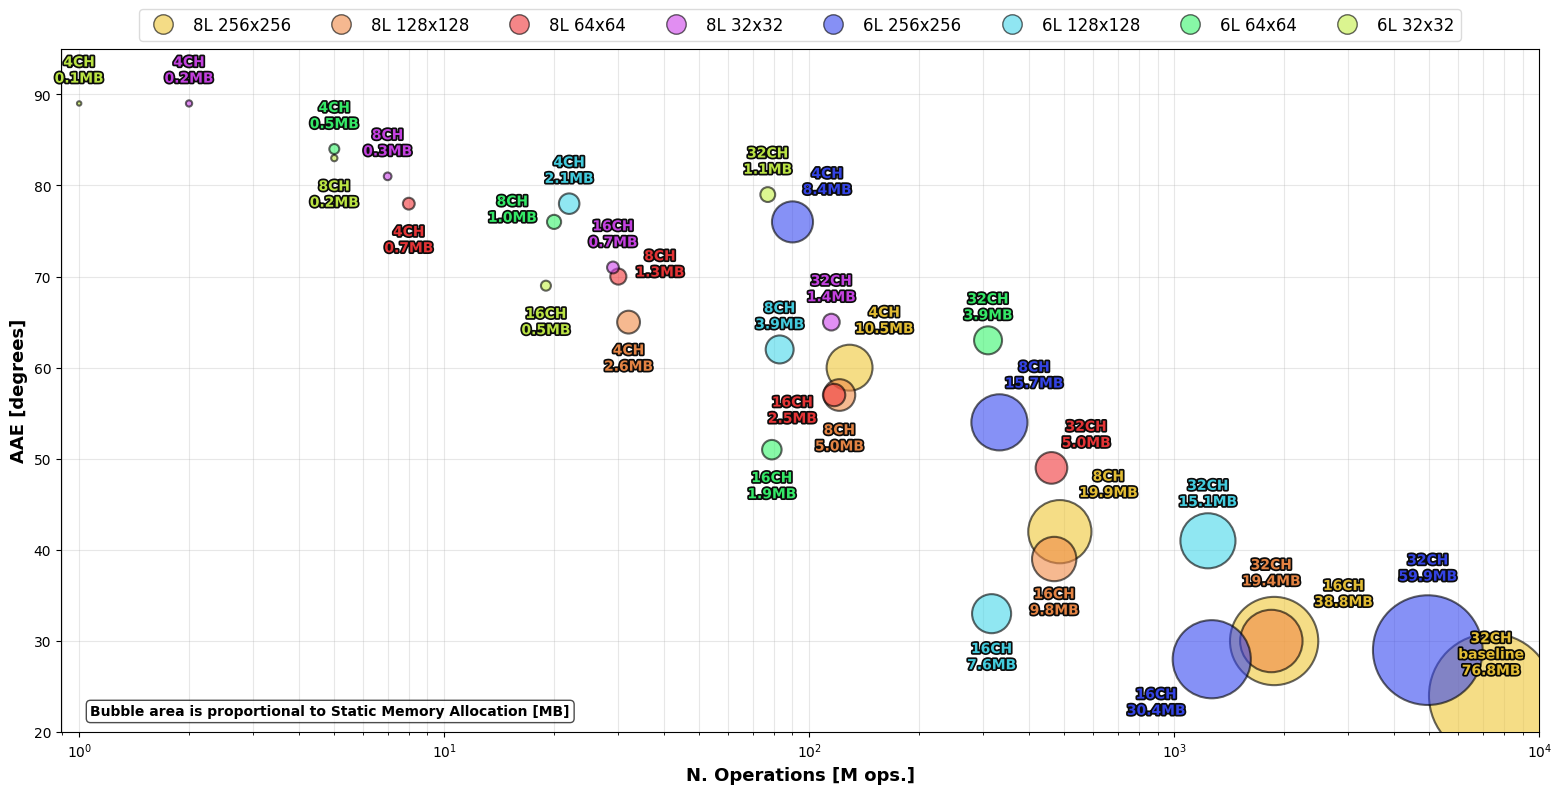

Total groups with data: 8
8L 32CH: 4 points
8L 16CH: 4 points
8L 8CH: 4 points
8L 4CH: 4 points
6L 32CH: 4 points
6L 16CH: 4 points
6L 8CH: 4 points
6L 4CH: 4 points

Memory allocation range: 0.10 - 76.80 MB
Bubble area range: 10 - 8000 points²


In [151]:
# BUBBLE PLOT

# CURVES BASED ON SPECIFIC MODELS BASED ON INPUT RESOLUTION (ANGULAR ERROR):
# 8 curves: FN/FNs with each resolution (256x256, 128x128, 64x64, 32x32) across all channels

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
import numpy as np

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, channel, and resolution information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]

# Create labels showing only channels (what varies along each curve)
df_filtered['Label'] = df_filtered['Channels'].astype(str) + 'CH'

# Group by layer type and resolution
layer_resolution_groups = {}
for layer_type in ['8L', '6L']:
    for res in ['256x256', '128x128', '64x64', '32x32']:
        key = f'{layer_type} {res}'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Resolution'] == res)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_resolution_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AAE [degrees]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 10000)
ax1.set_ylim(20, 95)
ax1.grid(True, alpha=0.3, which='both')

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 256x256': '#EFC737',    
    '8L 128x128': '#F08B47',   
    '8L 64x64': '#F03739',     
    '8L 32x32': '#CE45EB',     
    '6L 256x256': '#3748F0',   
    '6L 128x128': '#47D7EA',   
    '6L 64x64': '#38F56D',    
    '6L 32x32': '#C5F048'     
}

# Calculate bubble sizes based on memory allocation
# Linear scaling: area proportional to memory value
min_mem = df_filtered['Static Memory Allocation [MB]'].min()
max_mem = df_filtered['Static Memory Allocation [MB]'].max()
min_size = 10   # area for smallest bubble
max_size = 8000  # area for largest bubble

def scale_bubble_size(memory_value):
    # Linear scaling for area
    return min_size + (memory_value - min_mem) / (max_mem - min_mem) * (max_size - min_size)

# Manual label offset dictionary
# Key: (group_name, resolution), Value: (x_offset, y_offset)
label_offsets = {
    # Example: ('8L 346x260', '32CH'): (0, 25),
    # Fill in with your preferred offsets for each label
    # ('group_name', 'channels'): (x_offset, y_offset)
    ('6L 32x32', '8CH'): (0, -35),
    ('8L 64x64', '4CH'): (0, -35),
    ('6L 32x32', '16CH'): (0, -35),
    ('6L 64x64', '8CH'): (-30, 0),
    ('8L 128x128', '4CH'): (0, -35),
    ('8L 64x64', '8CH'): (30, 0),
    ('6L 64x64', '16CH'): (0, -35),
    ('8L 128x128', '8CH'): (0, -40),
    ('8L 64x64', '16CH'): (-30, -20),
    ('8L 256x256', '4CH'): (25, 25),
    ('6L 256x256', '4CH'): (25, 20),
    ('6L 128x128', '16CH'): (0, -40),
    ('6L 256x256', '8CH'): (25, 25),
    ('8L 128x128', '16CH'): (0, -40),
    ('8L 64x64', '32CH'): (25, 15),
    ('8L 256x256', '8CH'): (35, 25),
    ('6L 128x128', '32CH'): (0, 25),
    ('6L 256x256', '16CH'): (-40, -40),
    ('6L 256x256', '32CH'): (0, 50),
    ('8L 128x128', '32CH'): (0, 40),
    ('8L 256x256', '16CH'): (50, 25),
}
def get_label_offset(group_name, channels):
    return label_offsets.get((group_name, channels), (0, 15))  # Default offset if not specified
# Plot bubble scatter for each group
legend_handles = []
for group_name, df_group in layer_resolution_groups.items():
    # Sort by operations for consistent plotting
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Calculate bubble sizes for this group
    bubble_sizes = [scale_bubble_size(mem) for mem in df_group_sorted['Static Memory Allocation [MB]']]
    
    """ # Plot thin line connecting bubbles
    ax1.plot(df_group_sorted['N. Operations [M ops.]'],
             df_group_sorted['AAE [degrees]'],
             color=colors[group_name],
             linewidth=1.2,
             alpha=0.5,
             zorder=2) """
    
    # Plot scatter points with sizes based on memory allocation
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], 
               df_group_sorted['AAE [degrees]'], 
               s=bubble_sizes,
               color=colors[group_name], 
               alpha=0.6,
               edgecolor='black',
               linewidth=1.5,
               label=group_name, 
               zorder=3)
    
    # Add labels for each point showing both channels and memory
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 256x256' and row['Label'] == '32CH':
            label_text = f"{row['Label']}\nbaseline\n{row['Static Memory Allocation [MB]']:.1f}MB"
        else:
            label_text = f"{row['Label']}\n{row['Static Memory Allocation [MB]']:.1f}MB"
        offset_x, offset_y = get_label_offset(group_name, row['Label'])
        ax1.annotate(label_text, 
                    (row['N. Operations [M ops.]'], row['AAE [degrees]']), 
                    textcoords="offset points", 
                    xytext=(offset_x, offset_y), 
                    ha='center', 
                    fontsize=10, 
                    color=colors[group_name], 
                    fontweight='bold', 
                    alpha=0.95, 
                    zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])
    # Create legend handle with fixed size
    legend_handles.append(
        mlines.Line2D([], [], color=colors[group_name], marker='o', linestyle='None', markersize=14, label=group_name, markeredgecolor='black', alpha=0.6)
    )

legend = ax1.legend(handles=legend_handles, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

# Add a note about bubble size meaning
ax1.text(0.02, 0.02, 'Bubble area is proportional to Static Memory Allocation [MB]', 
        transform=ax1.transAxes, fontsize=10, fontweight='bold',
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_channel_groups)}")
for group_name, df_group in layer_channel_groups.items():
    print(f"{group_name}: {len(df_group)} points")
print(f"\nMemory allocation range: {min_mem:.2f} - {max_mem:.2f} MB")
print(f"Bubble area range: {scale_bubble_size(min_mem):.0f} - {scale_bubble_size(max_mem):.0f} points²")


/tmp/ipykernel_5352/1637392209.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 8000)


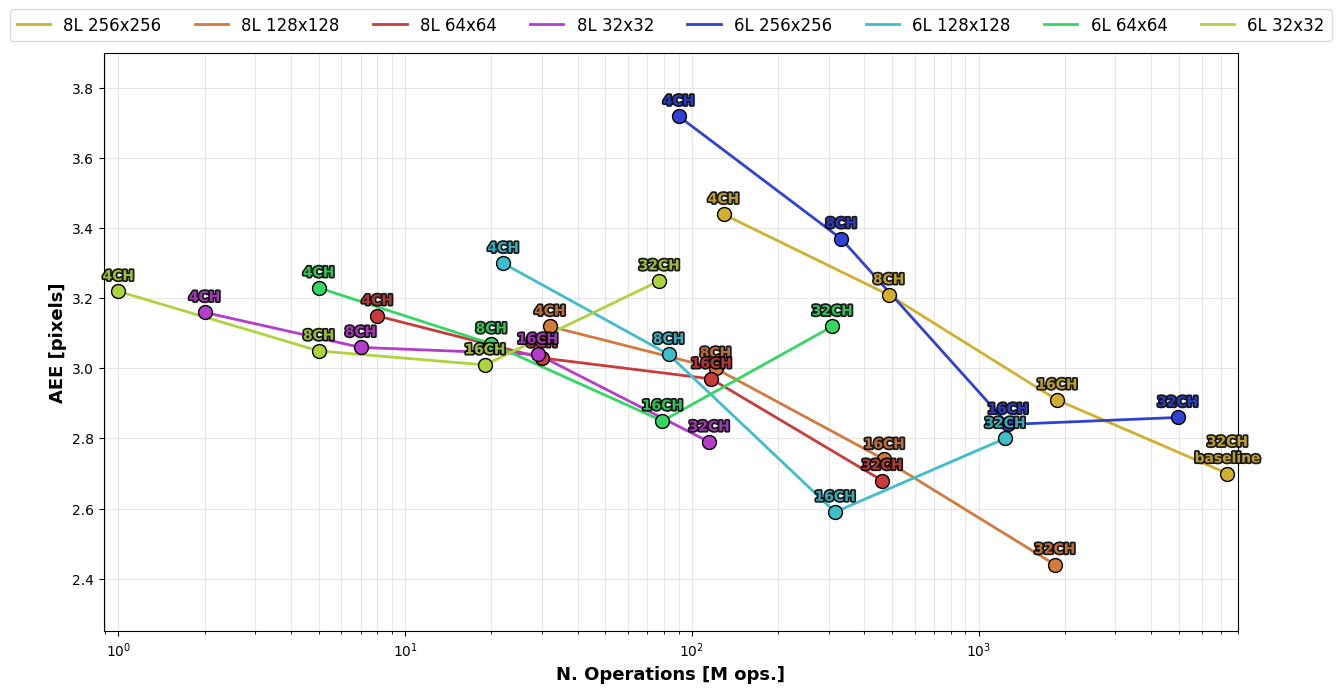

Total groups with data: 8
8L 256x256: 4 points
8L 128x128: 4 points
8L 64x64: 4 points
8L 32x32: 4 points
6L 256x256: 4 points
6L 128x128: 4 points
6L 64x64: 4 points
6L 32x32: 4 points


In [105]:
# CURVES BASED ON SPECIFIC MODELS BASED ON HIDDEN CHANNELS (MODULUS ERROR):
# 8 curves: FN/FNs with each resolution (256x256, 128x128, 64x64, 32x32) across all channels

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, resolution, and channel information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)

# Create labels showing only channels (what varies along each curve)
df_filtered['Label'] = df_filtered['Channels'].astype(str) + 'CH'

# Group by layer type and resolution
layer_resolution_groups = {}
for layer_type in ['8L', '6L']:
    for res in ['256x256', '128x128', '64x64', '32x32']:
        key = f'{layer_type} {res}'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Resolution'] == res)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_resolution_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AEE [pixels]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 8000)
ax1.set_ylim(2.25, 3.9)
ax1.grid(True, alpha=0.3, which='both')

""" # Second y axis for memory
ax2 = ax1.twinx()
ax2.set_ylabel('Static Memory Allocation [MB]', fontsize=13, fontweight='bold', labelpad=5)
ax2.set_ylim(0, max(df_filtered['Static Memory Allocation [MB]']) * 1.1) """

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 256x256': '#D3AF30',    
    '8L 128x128': '#D37A3F',   
    '8L 64x64': '#C83C3C',     
    '8L 32x32': '#B53CCD',     
    '6L 256x256': '#3041D3',   
    '6L 128x128': '#3EBDCD',   
    '6L 64x64': '#32D861',    
    '6L 32x32': '#AED33F'
}

# Plot memory bars for each group
bar_width_factor = 0.10
offset_start = 0.85
offset_step = 0.04
offset_factors = {key: offset_start + i * offset_step for i, key in enumerate(layer_resolution_groups.keys())}

""" for group_name, df_group in layer_resolution_groups.items():
    for idx, row in df_group.iterrows():
        bar_width = row['N. Operations [M ops.]'] * bar_width_factor
        ax2.bar(row['N. Operations [M ops.]'], 
               row['Static Memory Allocation [MB]'],
               width=bar_width, color=colors[group_name], alpha=0.2, align='center', 
               zorder=5, edgecolor='black', linewidth=1.0) """

# Plot curves for each group
for group_name, df_group in layer_resolution_groups.items():
    # Sort by runtime
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Plot line
    ax1.plot(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AEE [pixels]'], 
            linestyle='-', color=colors[group_name], linewidth=2, label=group_name, zorder=2)
    
    # Plot scatter points
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], df_group_sorted['AEE [pixels]'], 
               color=colors[group_name], s=100, edgecolor='black', zorder=3)
    
    # Add labels for each point (showing only channel count)
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 256x256' and row['Label'] == '32CH':
            label_text = f"\nbaseline"
        else:
            label_text = f""
        ax1.annotate(f"{row['Label']}{label_text}",
                    (row['N. Operations [M ops.]'], row['AEE [pixels]']), 
                    textcoords="offset points", xytext=(0, 8), ha='center', 
                    fontsize=10, color=colors[group_name], fontweight='bold', alpha=0.9, zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])

# Legend - outside and above the plot with light gray rounded rectangle
legend = ax1.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.09), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_resolution_groups)}")
for group_name, df_group in layer_resolution_groups.items():
    print(f"{group_name}: {len(df_group)} points")

/tmp/ipykernel_5352/1707747372.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim(0, 10000)


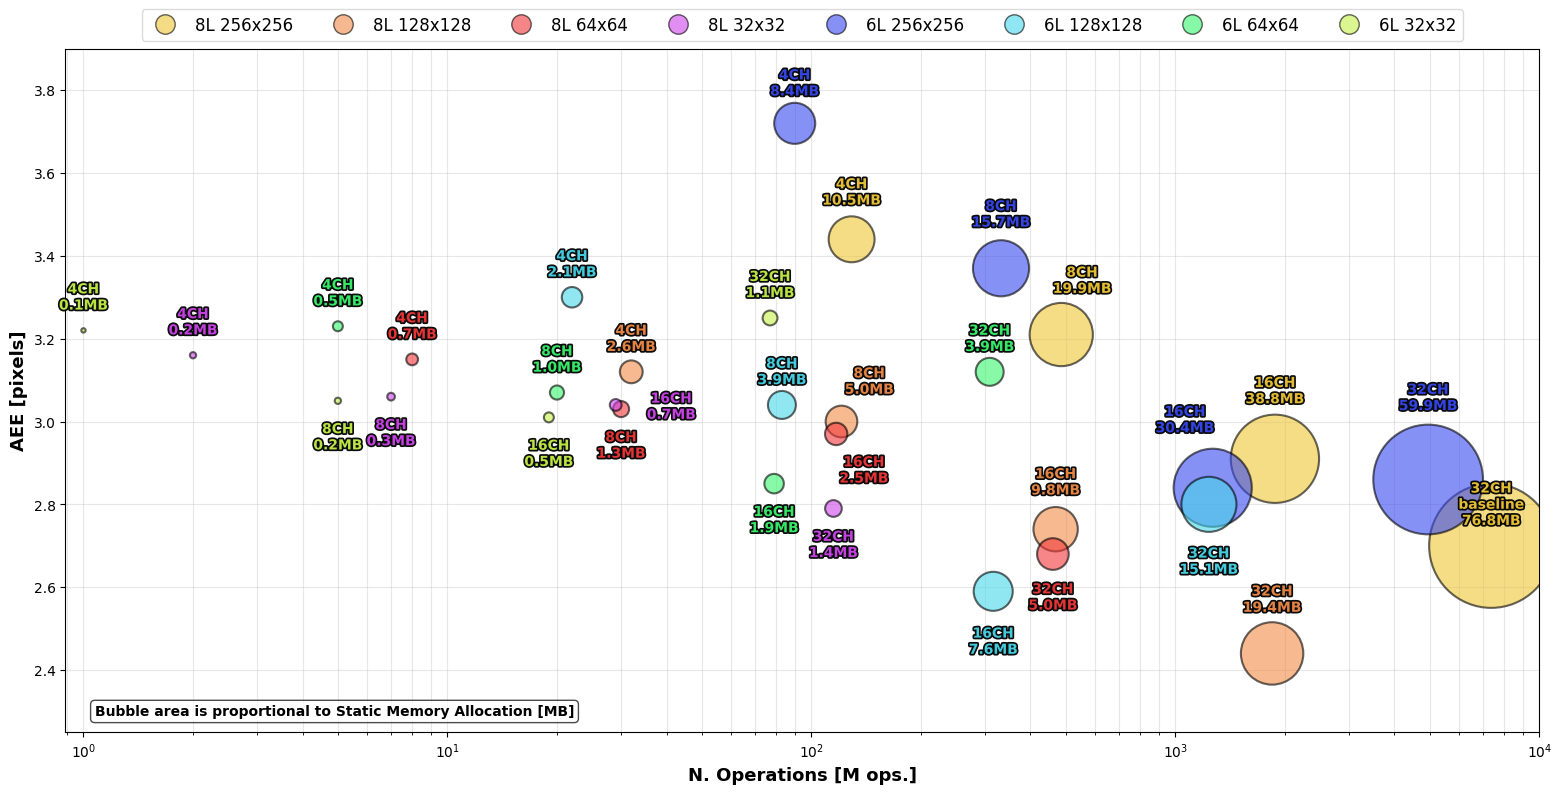

Total groups with data: 8
8L 32CH: 4 points
8L 16CH: 4 points
8L 8CH: 4 points
8L 4CH: 4 points
6L 32CH: 4 points
6L 16CH: 4 points
6L 8CH: 4 points
6L 4CH: 4 points

Memory allocation range: 0.10 - 76.80 MB
Bubble area range: 10 - 8000 points²


In [159]:
# BUBBLE PLOT

# CURVES BASED ON SPECIFIC MODELS BASED ON INPUT RESOLUTION (ENDPOINT ERROR):
# 8 curves: FN/FNs with each resolution (256x256, 128x128, 64x64, 32x32) across all channels

import matplotlib.lines as mlines
from matplotlib.patheffects import withStroke
import numpy as np

# Filter out rows with None Runtime values and exclude baseline
df_filtered = df_full[(df_full['N. Operations [M ops.]'].notna()) & (df_full['Model'] != 'baseline')].copy()

# Extract layer type, channel, and resolution information
# IMPORTANT: Check for 'FNs' first, then 'FN' to avoid misclassification
df_filtered['Layer_Type'] = df_filtered['Model'].str.extract(r'^(6L|8L)\b')[0]
df_filtered['Channels'] = df_filtered['Model'].str.extract(r'(\d+)CH')[0].astype(int)
df_filtered['Resolution'] = df_filtered['Model'].str.extract(r'(\d+x\d+)')[0]

# Create labels showing only channels (what varies along each curve)
df_filtered['Label'] = df_filtered['Channels'].astype(str) + 'CH'

# Group by layer type and resolution
layer_resolution_groups = {}
for layer_type in ['8L', '6L']:
    for res in ['256x256', '128x128', '64x64', '32x32']:
        key = f'{layer_type} {res}'
        group_data = df_filtered[
            (df_filtered['Layer_Type'] == layer_type) & 
            (df_filtered['Resolution'] == res)
        ].copy()
        # Only add groups that have data
        if len(group_data) > 0:
            layer_resolution_groups[key] = group_data

# Create figure
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.set_facecolor('none')
fig.patch.set_alpha(0.0)

# Axes labels and limits
ax1.set_xlabel('N. Operations [M ops.]', fontsize=13, fontweight='bold')
ax1.set_ylabel('AEE [pixels]', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.set_xlim(0, 10000)
ax1.set_ylim(2.25, 3.9)
ax1.grid(True, alpha=0.3, which='both')

# Define colors for the eight groups (using a diverse color palette)
colors = {
    '8L 256x256': '#EFC737',    
    '8L 128x128': '#F08B47',   
    '8L 64x64': '#F03739',     
    '8L 32x32': '#CE45EB',     
    '6L 256x256': '#3748F0',   
    '6L 128x128': '#47D7EA',   
    '6L 64x64': '#38F56D',    
    '6L 32x32': '#C5F048'     
}

# Calculate bubble sizes based on memory allocation
# Linear scaling: area proportional to memory value
min_mem = df_filtered['Static Memory Allocation [MB]'].min()
max_mem = df_filtered['Static Memory Allocation [MB]'].max()
min_size = 10   # area for smallest bubble
max_size = 8000  # area for largest bubble

def scale_bubble_size(memory_value):
    # Linear scaling for area
    return min_size + (memory_value - min_mem) / (max_mem - min_mem) * (max_size - min_size)

# Manual label offset dictionary
# Key: (group_name, resolution), Value: (x_offset, y_offset)
label_offsets = {
    # Example: ('8L 346x260', '32CH'): (0, 25),
    # Fill in with your preferred offsets for each label
    # ('group_name', 'channels'): (x_offset, y_offset)
    ('6L 32x32', '8CH'): (0, -35),
    ('8L 32x32', '8CH'): (0, -35),
    ('6L 32x32', '16CH'): (0, -35),
    ('8L 64x64', '8CH'): (0, -35),
    ('6L 64x64', '16CH'): (0, -35),
    ('8L 32x32', '32CH'): (0, -35),
    ('8L 32x32', '16CH'): (40, -10),
    ('8L 64x64', '16CH'): (20, -35),
    ('6L 256x256', '4CH'): (0, 20),
    ('8L 256x256', '4CH'): (0, 25),
    ('8L 128x128', '8CH'): (20, 20),
    ('6L 128x128', '16CH'): (0, -45),
    ('8L 64x64', '32CH'): (0, -40),
    ('8L 128x128', '16CH'): (0, 25),
    ('6L 256x256', '8CH'): (0, 30),
    ('8L 256x256', '8CH'): (15, 30),
    ('6L 128x128', '32CH'): (0, -50),
    ('8L 256x256', '16CH'): (0, 40),
    ('6L 256x256', '32CH'): (0, 50),
    ('6L 256x256', '16CH'): (-20, 40),
    ('8L 128x128', '32CH'): (0, 30),
    
}
def get_label_offset(group_name, channels):
    return label_offsets.get((group_name, channels), (0, 15))  # Default offset if not specified
# Plot bubble scatter for each group
legend_handles = []
for group_name, df_group in layer_resolution_groups.items():
    # Sort by operations for consistent plotting
    df_group_sorted = df_group.sort_values('N. Operations [M ops.]')
    
    # Calculate bubble sizes for this group
    bubble_sizes = [scale_bubble_size(mem) for mem in df_group_sorted['Static Memory Allocation [MB]']]
    
    """ # Plot thin line connecting bubbles
    ax1.plot(df_group_sorted['N. Operations [M ops.]'],
             df_group_sorted['AEE [pixels]'],
             color=colors[group_name],
             linewidth=1.2,
             alpha=0.5,
             zorder=2) """
    
    # Plot scatter points with sizes based on memory allocation
    ax1.scatter(df_group_sorted['N. Operations [M ops.]'], 
               df_group_sorted['AEE [pixels]'], 
               s=bubble_sizes,
               color=colors[group_name], 
               alpha=0.6,
               edgecolor='black',
               linewidth=1.5,
               label=group_name, 
               zorder=3)
    
    # Add labels for each point showing both channels and memory
    for idx, row in df_group_sorted.iterrows():
        # Add 'baseline' to the label for 8L 32CH 256x256
        if group_name == '8L 256x256' and row['Label'] == '32CH':
            label_text = f"{row['Label']}\nbaseline\n{row['Static Memory Allocation [MB]']:.1f}MB"
        else:
            label_text = f"{row['Label']}\n{row['Static Memory Allocation [MB]']:.1f}MB"
        offset_x, offset_y = get_label_offset(group_name, row['Label'])
        ax1.annotate(label_text, 
                    (row['N. Operations [M ops.]'], row['AEE [pixels]']), 
                    textcoords="offset points", 
                    xytext=(offset_x, offset_y), 
                    ha='center', 
                    fontsize=10, 
                    color=colors[group_name], 
                    fontweight='bold', 
                    alpha=0.95, 
                    zorder=11,
                    path_effects=[withStroke(linewidth=2.5, foreground='black')])
    # Create legend handle with fixed size
    legend_handles.append(
        mlines.Line2D([], [], color=colors[group_name], marker='o', linestyle='None', markersize=14, label=group_name, markeredgecolor='black', alpha=0.6)
    )

legend = ax1.legend(handles=legend_handles, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.07), ncol=8, 
                   frameon=True, fancybox=True, shadow=False, 
                   facecolor='white', edgecolor='lightgray', framealpha=0.8)

# Add a note about bubble size meaning
ax1.text(0.02, 0.02, 'Bubble area is proportional to Static Memory Allocation [MB]', 
        transform=ax1.transAxes, fontsize=10, fontweight='bold',
        verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

fig.tight_layout()
plt.show()

# Print summary
print(f"Total groups with data: {len(layer_channel_groups)}")
for group_name, df_group in layer_channel_groups.items():
    print(f"{group_name}: {len(df_group)} points")
print(f"\nMemory allocation range: {min_mem:.2f} - {max_mem:.2f} MB")
print(f"Bubble area range: {scale_bubble_size(min_mem):.0f} - {scale_bubble_size(max_mem):.0f} points²")